# notebook 3 - batch correction

This notebook will introduce you very briefly to the process of batch correction.

In [1]:
#import necessary python packages
import scanpy.api as sc #software suite of tools for single-cell analysis in python
import besca as bc #internal BEDA package for single cell analysis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sc.logging.print_versions() #output an overview of the software versions that are loaded

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.16.2 scipy==1.4.1 pandas==0.24.1 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
from IPython.display import HTML
task = "<style>div.task { background-color: #ffc299; border-color: #ff944d; border-left: 7px solid #ff944d; padding: 1em;} </style>"
HTML(task)

In [3]:
tag = "<style>div.tag { background-color: #99ccff; border-color: #1a8cff; border-left: 7px solid #1a8cff; padding: 1em;} </style>"
HTML(tag)

In [4]:
FAIR = "<style>div.fair { background-color: #d2f7ec; border-color: #d2f7ec; border-left: 7px solid #2fbc94; padding: 1em;} </style>"
HTML(FAIR)

## Dataset

Here we will reload the dataset we wrote out after performing the regressout to perform a batch correction on Donor.

In [5]:
adata = sc.read('/tmp/adata_pbmc_FRESH_regressedOut.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 9461 × 1599 
    obs: 'CELL', 'CONDITION', 'experiment', 'sample_type', 'storage_condition', 'donor', 'batch', 'n_counts', 'n_genes', 'percent_mito'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads', 'mean', 'mean_log1p', 'coeffvar', 'coeffvar_log1p'

## Batch correction

After normalization, there could still be confounders in the data. Technical confounders (batch effects) can arise from difference in reagents, isolation methods, the lab/experimenter who performed the experiment, even which day/time the experiment was performed. Further factors like cell size, cell cycle phase , etc. can introduce unwanted variance in your data that may not be of biological interest. Various approaches exist that can account for and, ideally, remove technical confounders, this is called a **batch correction**. In general technical confounders can only be removed if the **batch effect is orthogonal to the biological differences in each batch**! In cases were this is not the case applying a batch correction does not make sense since you will never be able to differentiate if the result of significant differences are due to the batch or true biological differences. 

In this example we are applying a batch correction to a dataset where this important condition is not fullfilled since our batches are parallel to biological differences (we define each Donor as its own batch)! This example is only intended as a demonstration of how to perform a batch correction and the output we generate does not give any scientific insights.

Here we will discuss a batch correction based on the **mutual nearest neighbors** (in python mnnpy) since this is the one we most commonly use, but there are many other approaches as well.

In this approach we assume that the two batches contain at least one common cell type and that the batch effects is orthogonal to the biological differences in each batch. The algorithm then identifies matching cell types in each batch by finding MNN pairs of cells. It calculates the differences between these celltypes and applies it to the dataset to bring the cells together.

In [7]:
#perform the batch correction using mnnpy and besca
adata = bc.st.batch_correction(adata, 'donor')

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.
postprocessing performed. adata contains original .raw


In [8]:
adata.write('/tmp/dataset_introduction/adata_pbmc_FRESH_batch_corrected.h5ad')

In [9]:
adata = sc.read('/tmp/dataset_introduction/adata_pbmc_FRESH_batch_corrected.h5ad')

<div class="tag">
Because the batch correction takes a long time to run you should always write out the corrected AnnData object so you can easily load it back in and do not need to repeat the batch correction.
    
</div>

In [10]:
adata.obs.donor.value_counts()

1    3877
0    2932
2    2652
Name: donor, dtype: int64

<div class="tag">
Note through the batch correction function our Donors were renamed (was previously a categorical variable and now it only shows the integer value). In addition our index was modified to show which cells belonged to which batch. We will fix this below so that the values match our previous analysis and we can more easily compare.
    
</div>

In [11]:
#index is changed through the batch correction process. 
adata.obs.index = adata.obs.CELL

In [13]:
#rename the Donors
adata.obs.donor = adata.obs.donor.to_frame().replace({'1':'Donor_1' , '2':'Donor_3A', '0':'Donor_2'}).donor

## perform the rest of the dataprocessing pipeline

### principle component analysis

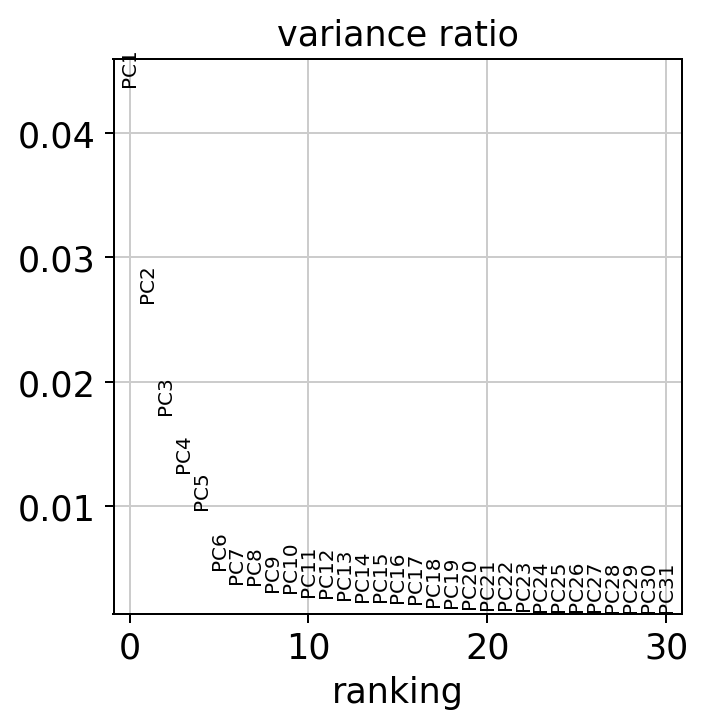

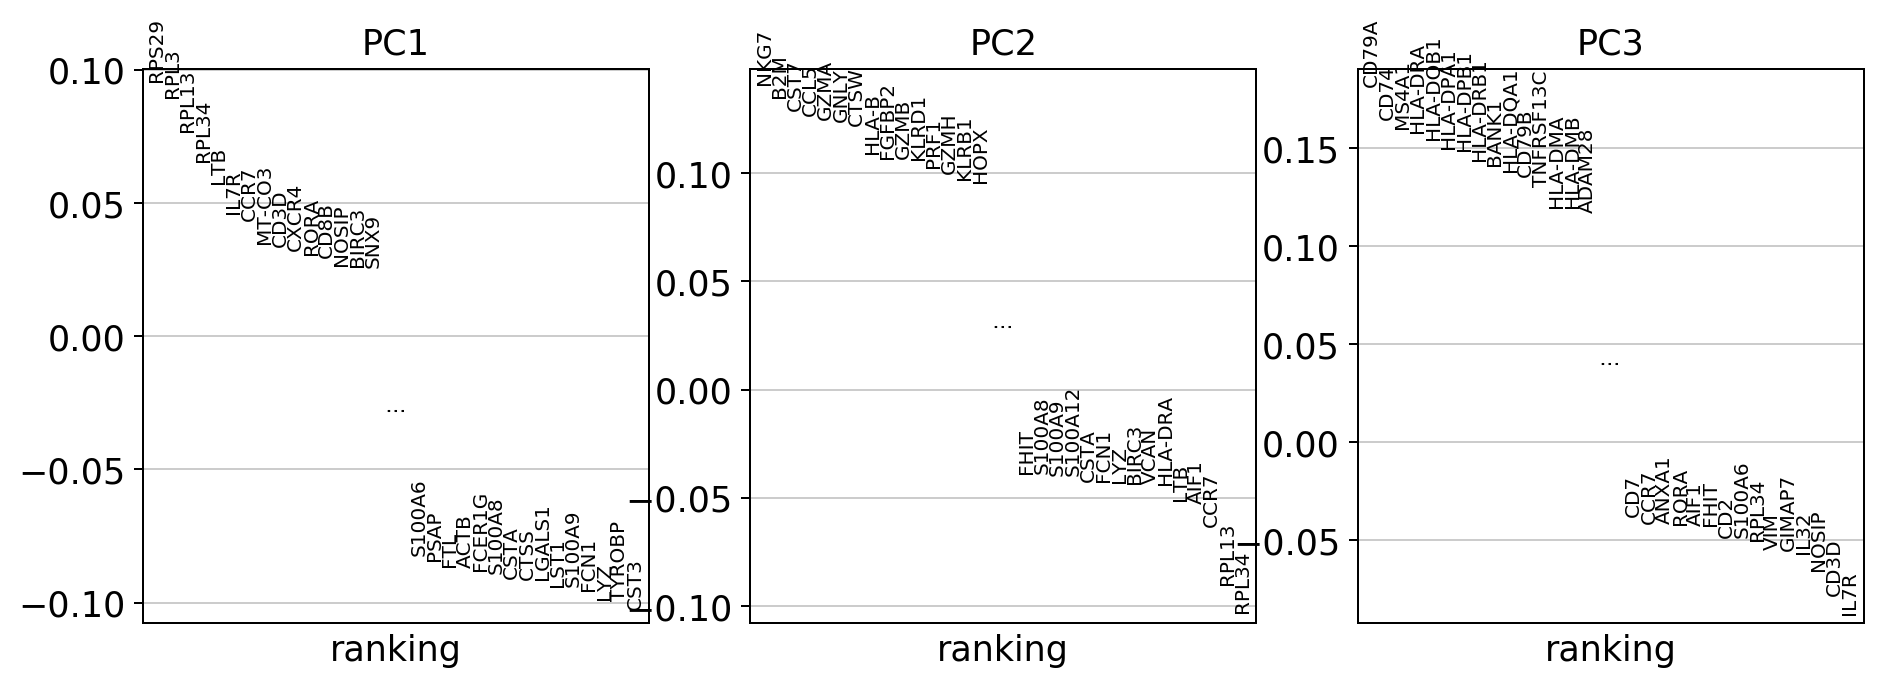

In [14]:
#define random seed
random_seed = 0

sc.settings.set_figure_params(dpi=90)

#calculate 50 principle components of the dataset
sc.tl.pca(adata, random_state=random_seed, svd_solver='arpack')

#visualize the amount of variance explained by each PC
sc.pl.pca_variance_ratio(adata)

#visualize the loadings onto the first 3 PCs
sc.pl.pca_loadings(adata)

<div class="tag">
Compared to the uncorrected dataset we looked at previously we can see that the amount of variance explained by each PC is less (scale on last plot went up to 0.5). This makes sense since we have removed additional variance from the dataset.
    
</div>

#### nearest neighbor calculation

Computes a neighborhood graph of the cells based on the first 50 principle components.

In [15]:
sc.pp.neighbors(adata, n_neighbors=15, random_state = random_seed, n_pcs=50)

#### louvain clustering

In [16]:
sc.tl.louvain(adata, random_state=random_seed)

### UMAP & t-SNE

In [17]:
%%time
sc.tl.umap(adata, random_state = random_seed)

CPU times: user 24.8 s, sys: 254 ms, total: 25.1 s
Wall time: 25 s


In [18]:
%%time
sc.tl.tsne(adata, random_state = random_seed)

CPU times: user 1min 10s, sys: 315 ms, total: 1min 10s
Wall time: 1min 10s


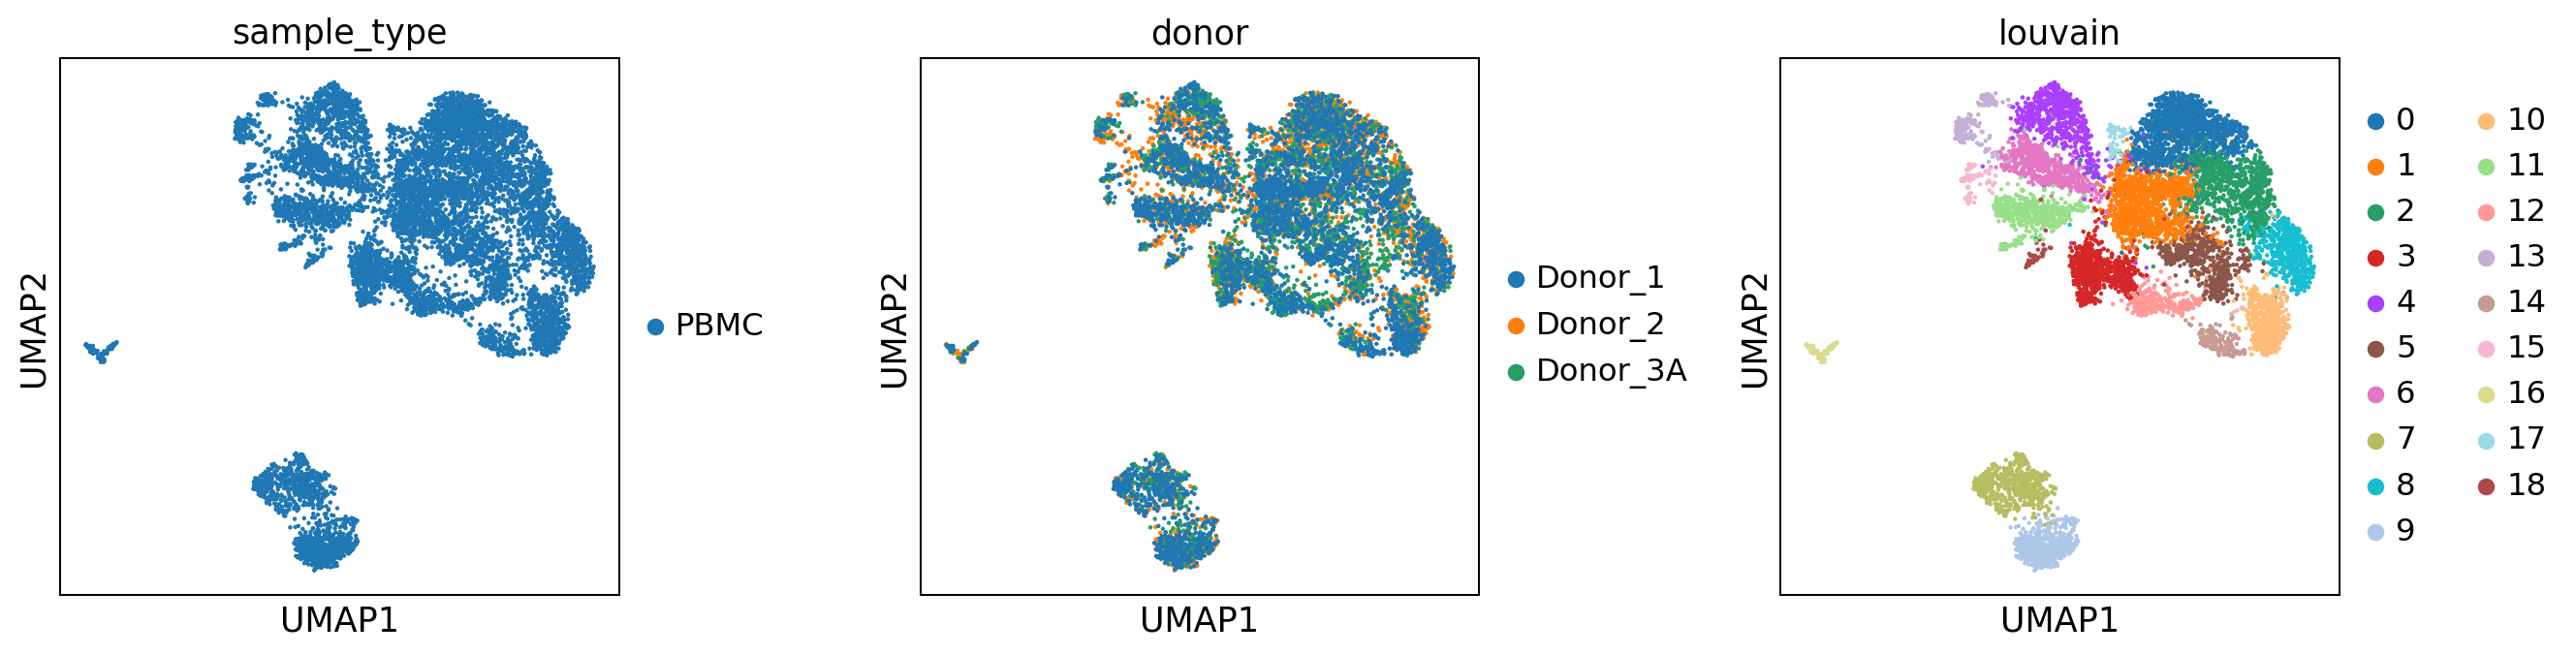

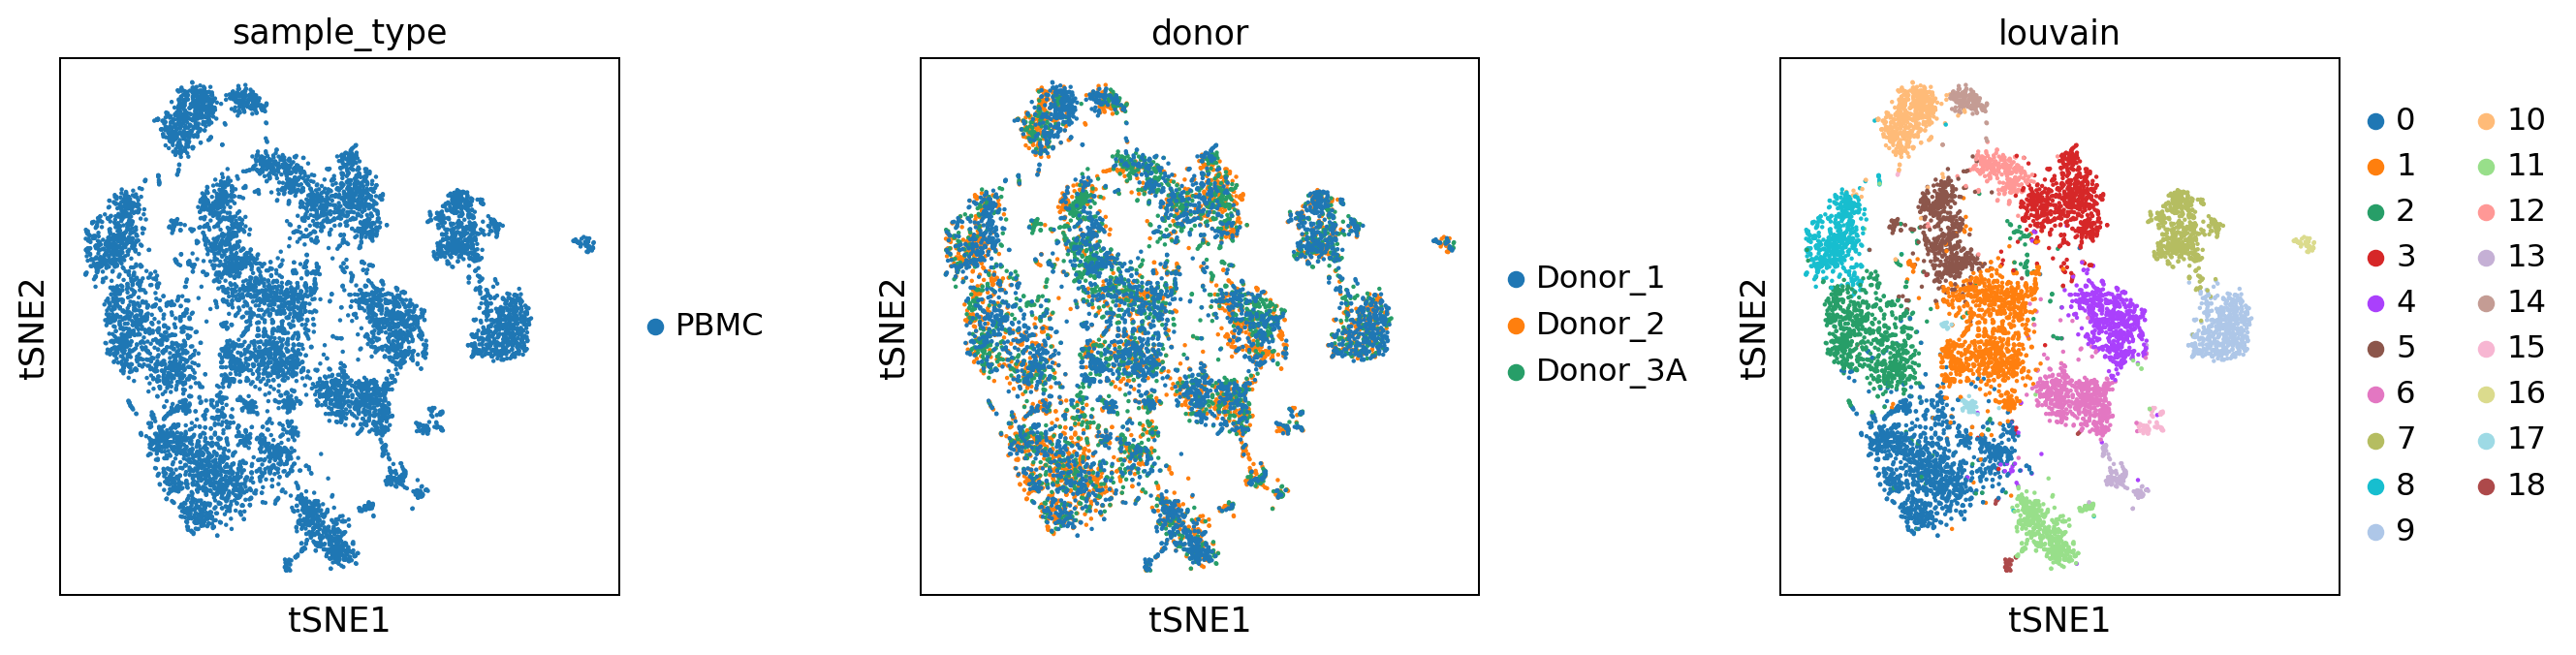

In [19]:
sc.pl.umap(adata, color = ['sample_type', 'donor', 'louvain'], wspace = 0.4)
sc.pl.tsne(adata, color = ['sample_type', 'donor', 'louvain'], wspace = 0.4)

## Comparision with uncorrected dataset

In [20]:
#read in uncorrected dataset
uncorrected_adata = sc.read('/tmp/dataset_introduction/adata_pbmc_FRESH_processed_annotated.h5ad')

uncorrected


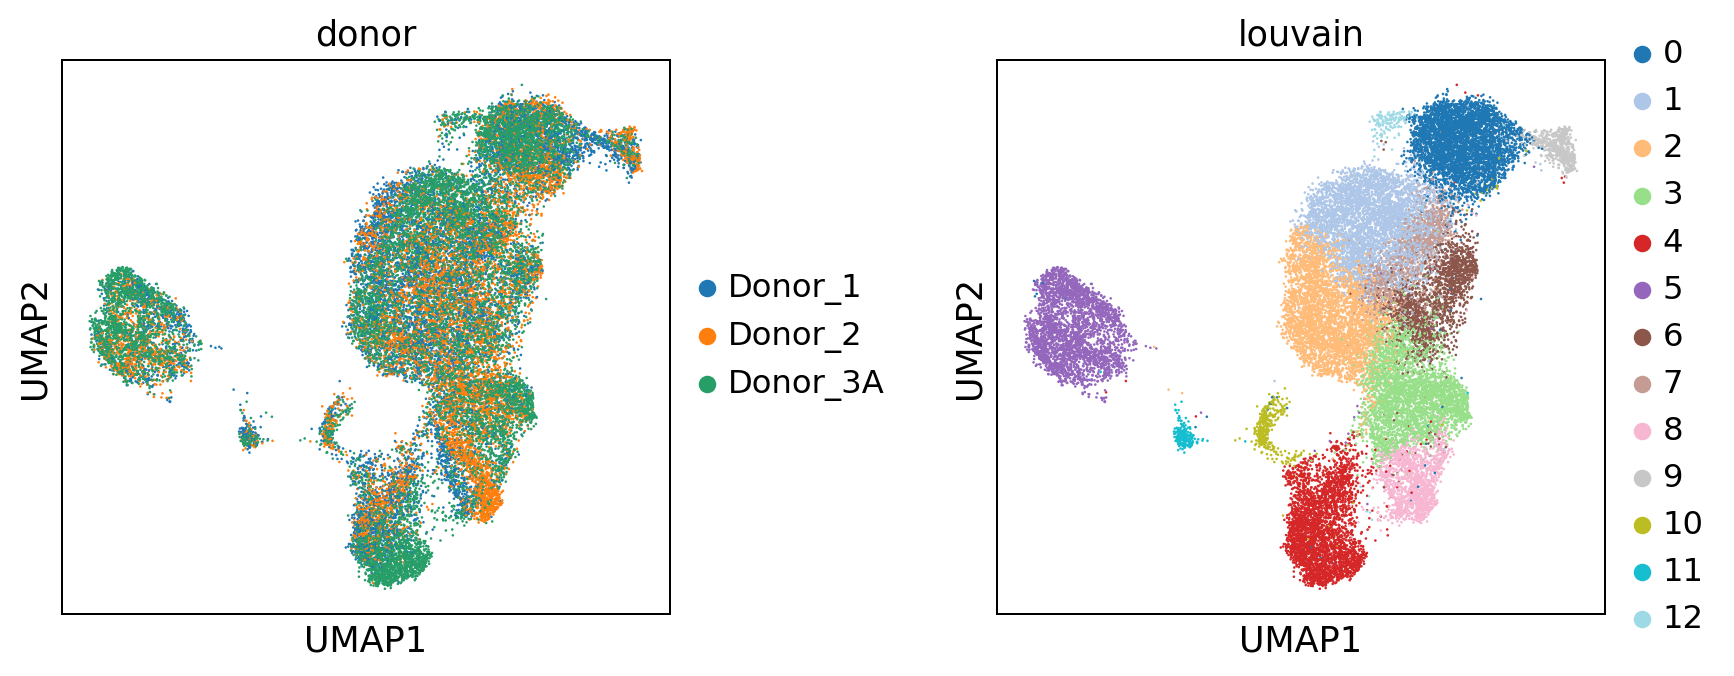

corrected


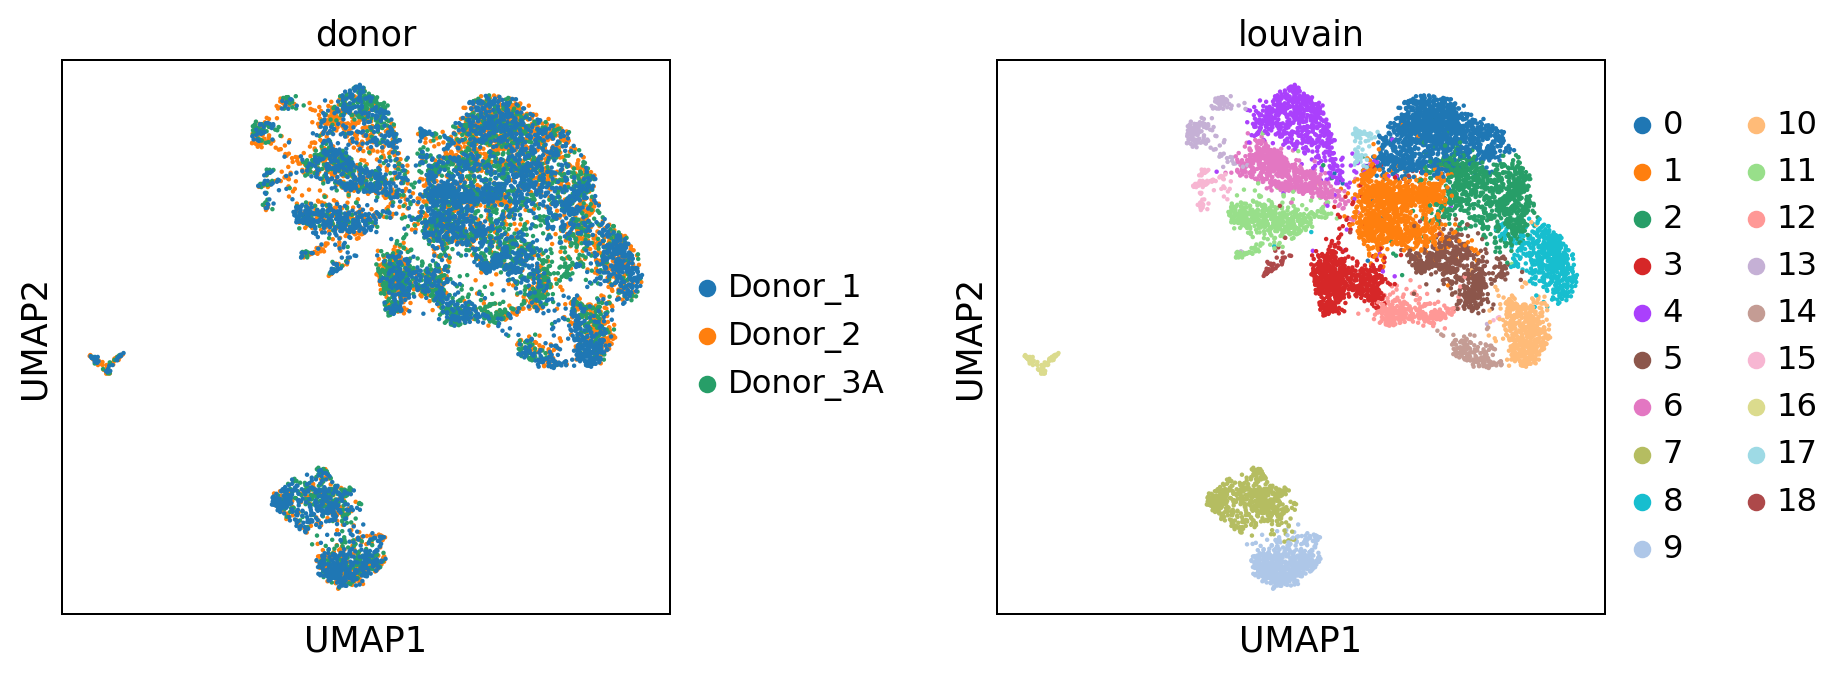

In [21]:
##comparision of louvain clustering with unbatchcorrected dataset
print('uncorrected')
sc.pl.umap(uncorrected_adata, color = ['donor', 'louvain'], wspace = 0.4)
print('corrected')
sc.pl.umap(adata, color = ['donor', 'louvain'], wspace = 0.4)

In [22]:
#import previosly done celltype annotation to batch corrected dataset 
#(do not need to go through the process of reannotating our cells)
bc.import.add_cell_labeling(adata=adata, filepath='/tmp/dataset_introduction/labelings/celltype/', label = 'celltype')

uncorrected


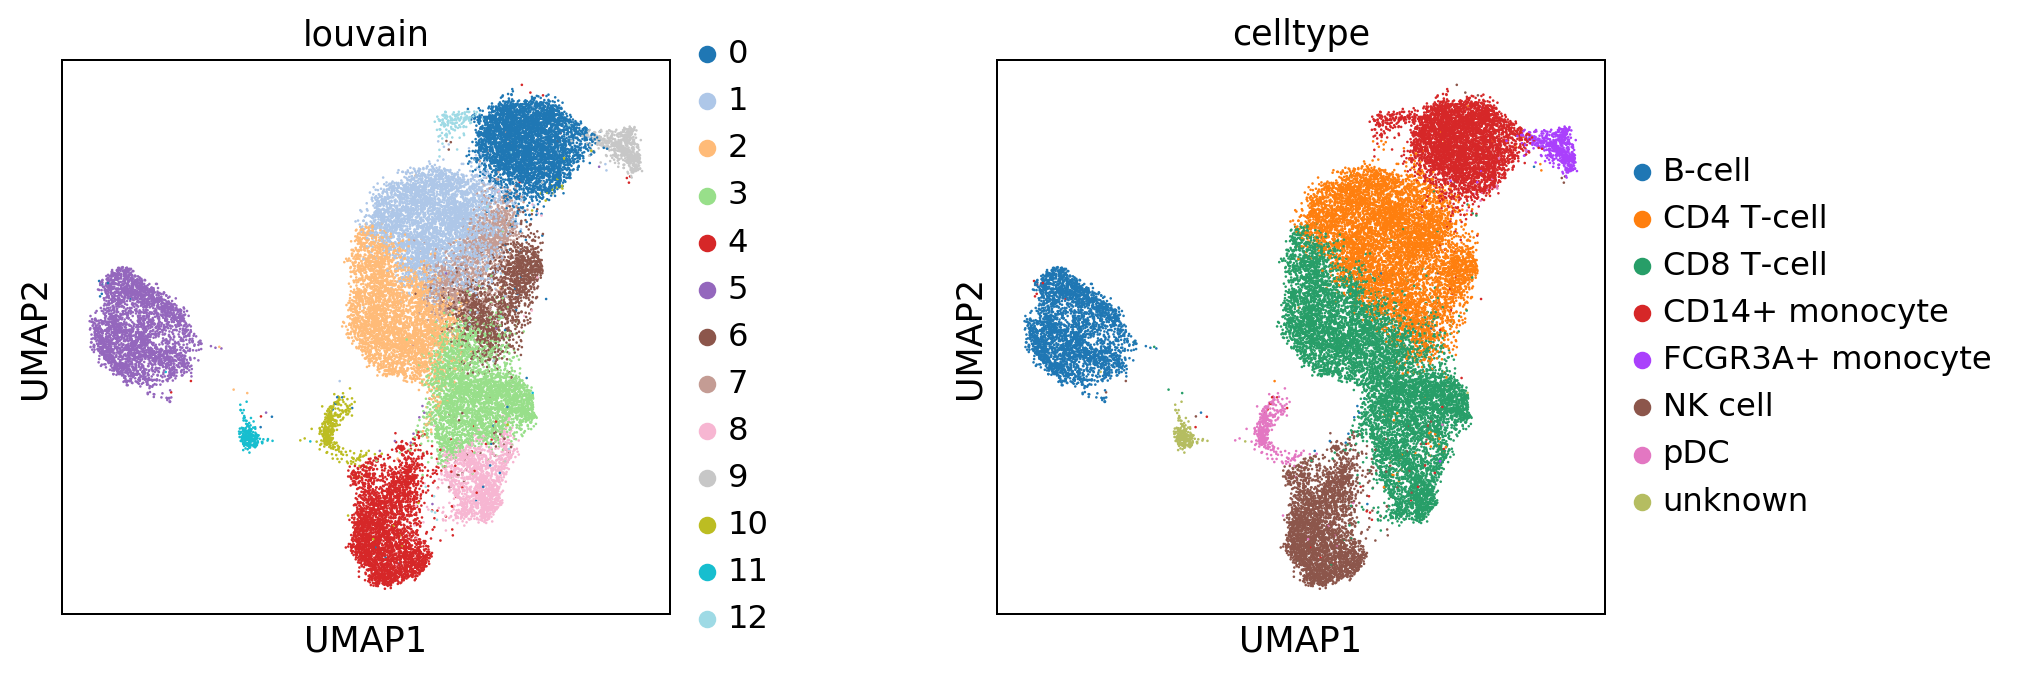

corrected


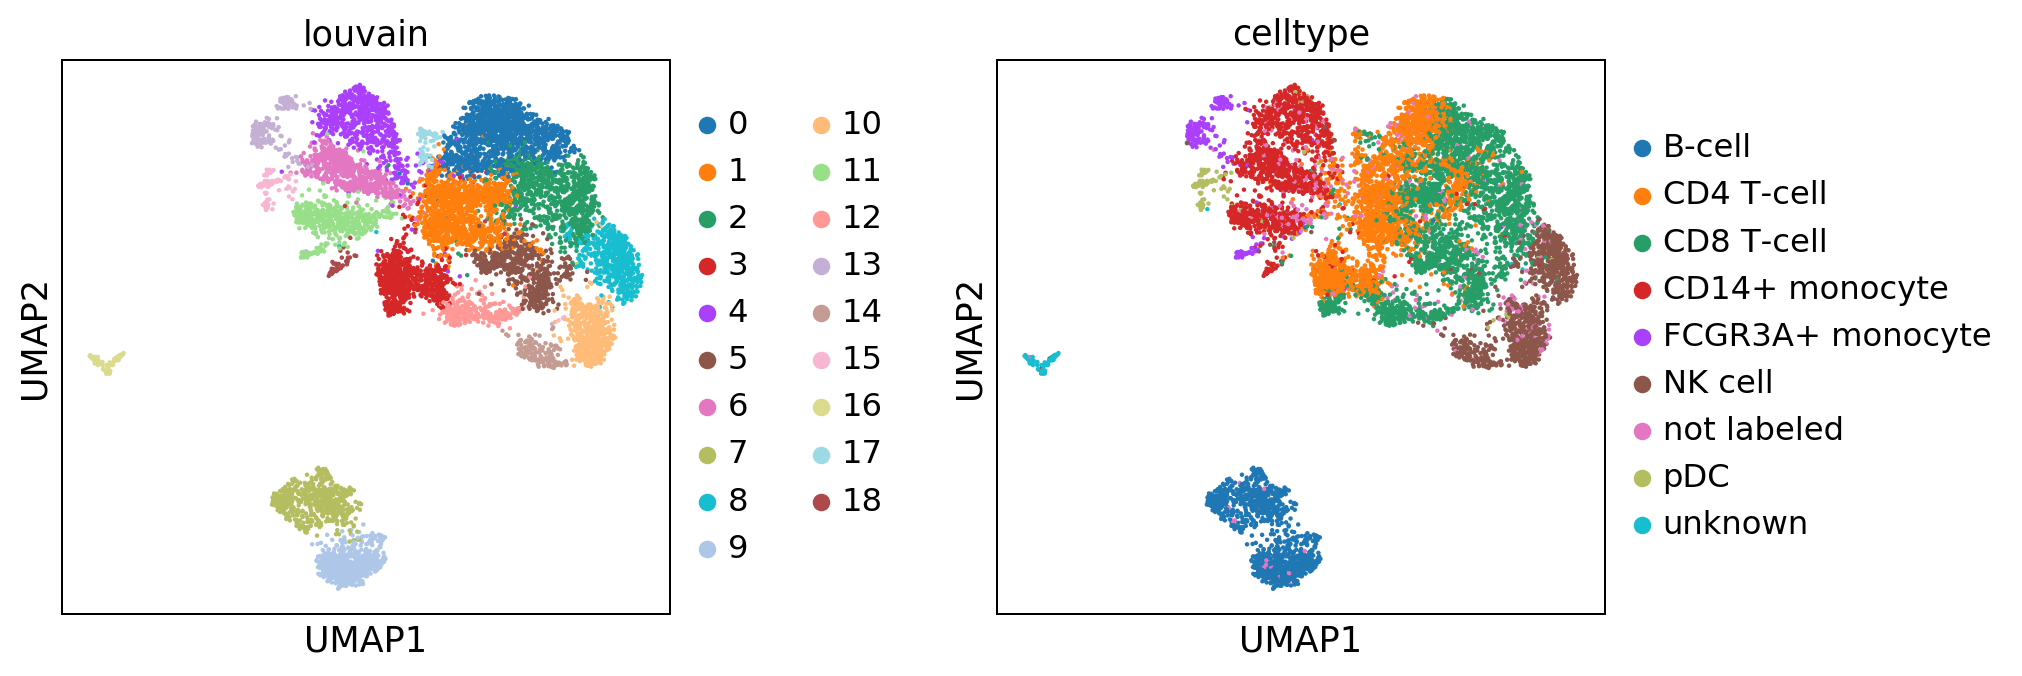

In [23]:
print('uncorrected')
sc.pl.umap(uncorrected_adata, color = ['louvain', 'celltype'], wspace = 0.4)
print('corrected')
sc.pl.umap(adata, color = ['louvain', 'celltype'], wspace = 0.4)